# **covid-19-in-South-Korea**

*Author*: Huey Kim [Github](https://github.com/hwuiwon)

We will use [Data Science for COVID-19 dataset](https://www.kaggle.com/kimjihoo/coronavirusdataset) provided by DS4C at Kaggle.

## **Introduction**

### **List of Files**

*Encoding*: UTF-8

*   **Case.csv** (Data of COVID-19 infection cases)
*   **PatientInfo.csv** (Epidemiological data of COVID-19 patients)
*   **PatientRoute.csv** (Route data of COVID-19 patients)
*   **Region.csv** (Location and statistical data of the regions) ✔️
*   **SearchTrend.csv** (Trend data of the keywords searched in NAVER which is one of the largest portals) ✔️
*   **SeoulFloating.csv** (Data of floating population in Seoul, South Korea (from SK Telecom Big Data Hub))
*   **Time.csv** (Time series data of COVID-19 status) ✔️
*   **TimeAge.csv** (Time series data of COVID-19 status in terms of the age) ✔️
*   **TimeGender.csv** (Time series data of COVID-19 status in terms of gender) ✔️
*   **TimeProvince.csv** (Time series data of COVID-19 status in terms of the Province) ✔️
*   **Weather.csv** (Data of the weather in the regions)

### **Setting Environment**

In [0]:
DIR_PATH = '/content/drive/My Drive/Colab Notebooks/data/kr-corona-dataset/'

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os;
import numpy as np;
import pandas as pd;
import seaborn as sns;
import folium;
import matplotlib.pyplot as plt;
import matplotlib.ticker as ticker

sns.set_style('darkgrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **External Datasets**

**Population Distribution Data**

* from [Ministry of the Interior and Safety](http://27.101.213.4/)

File Name: *PopulationDistribution.csv* (as of March)

Use this code to convert file with encoding **EUC-KR** to **UTF-8**.
```
iconv -f euc-kr -t utf-8 old.csv > new.csv
```

In [3]:
# Importing data: PopulationDistribution
pop_dist = pd.read_csv(os.path.join(DIR_PATH, 'PopulationDistribution.csv'))
pop_dist = pop_dist.iloc[:, np.r_[0, 1, 3:12, 14:15, 27]]
pop_dist.columns = ['location', 'total', '0s', '10s', '20s', '30s', '40s', '50s',
                   '60s', '70s', '80s', 'male_total', 'female_total']
pop_dist.head()

,location,total,0s,10s,20s,30s,40s,50s,60s,70s,80s,male_total,female_total
0,전국 (0000000000),"51,843,195","4,119,475","4,902,009","6,799,238","7,006,749","8,375,429","8,662,400","6,426,006","3,623,899","1,667,665","25,858,743","25,984,452"
1,서울특별시 (1100000000),"9,733,655","655,134","810,349","1,461,212","1,501,662","1,558,128","1,537,114","1,205,699","691,028","266,097","4,742,217","4,991,438"
2,부산광역시 (2600000000),"3,409,932","240,857","279,909","435,280","430,494","516,889","579,584","513,485","286,808","110,254","1,672,252","1,737,680"
3,대구광역시 (2700000000),"2,433,568","185,945","233,311","322,594","302,617","390,628","428,955","313,213","171,945","74,745","1,202,273","1,231,295"
4,인천광역시 (2800000000),"2,952,689","238,763","279,780","405,826","416,119","489,213","515,257","347,493","172,868","74,768","1,479,839","1,472,850"


**Province Geolocation Data**
* from [GEOSERVICE](http://www.gisdeveloper.co.kr/?p=2332)

File Name: *province_geo.json*

## **By Gender**

### **Assumption**

There will be no correlation between gender and COVID-19 infection.

### **Visualization**

In [4]:
# Importing data: Gender
gender = pd.read_csv(os.path.join(DIR_PATH, 'TimeGender.csv'))
gender.head(2)

,date,time,sex,confirmed,deceased
0,2020-03-02,0,male,1591,13
1,2020-03-02,0,female,2621,9


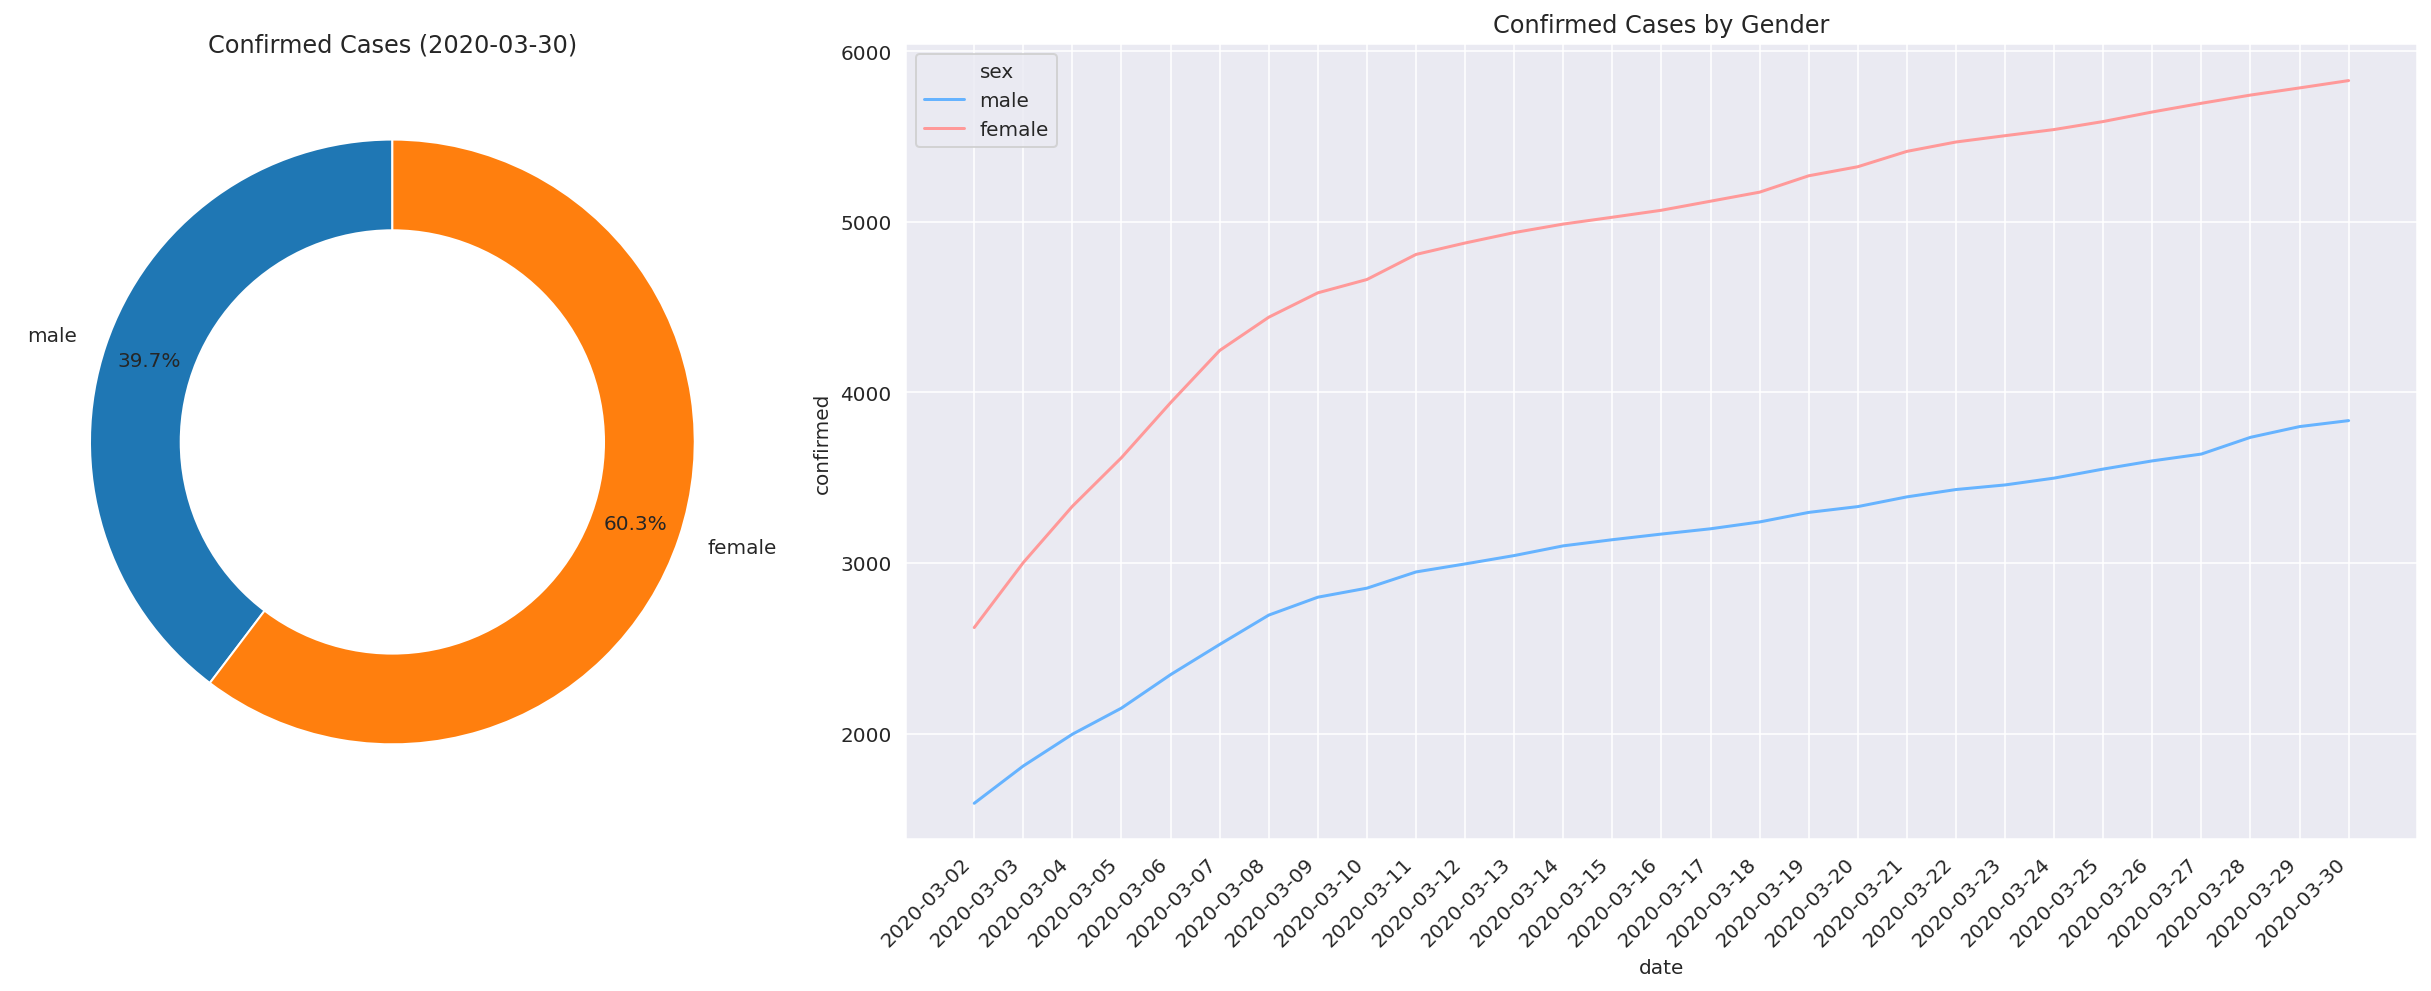

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17, 7), gridspec_kw={'width_ratios': [1, 2]})
sns.set_palette(['#66b3ff','#ff9999'])

# Donut plot of confirmed cases by gender
ax1.title.set_text('Confirmed Cases ({0})'.format(gender.iloc[-1, 0]))
ax1.pie(gender.confirmed[-2:], labels=['male', 'female'], autopct='%.1f%%',
        startangle=90, pctdistance=0.85)
ax1.add_artist(plt.Circle((0, 0), 0.7, fc='white'))

# Change in time of confirmed cases
ax2.title.set_text('Confirmed Cases by Gender')
sns.lineplot(data=gender, x='date', y='confirmed', hue='sex', ax=ax2)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

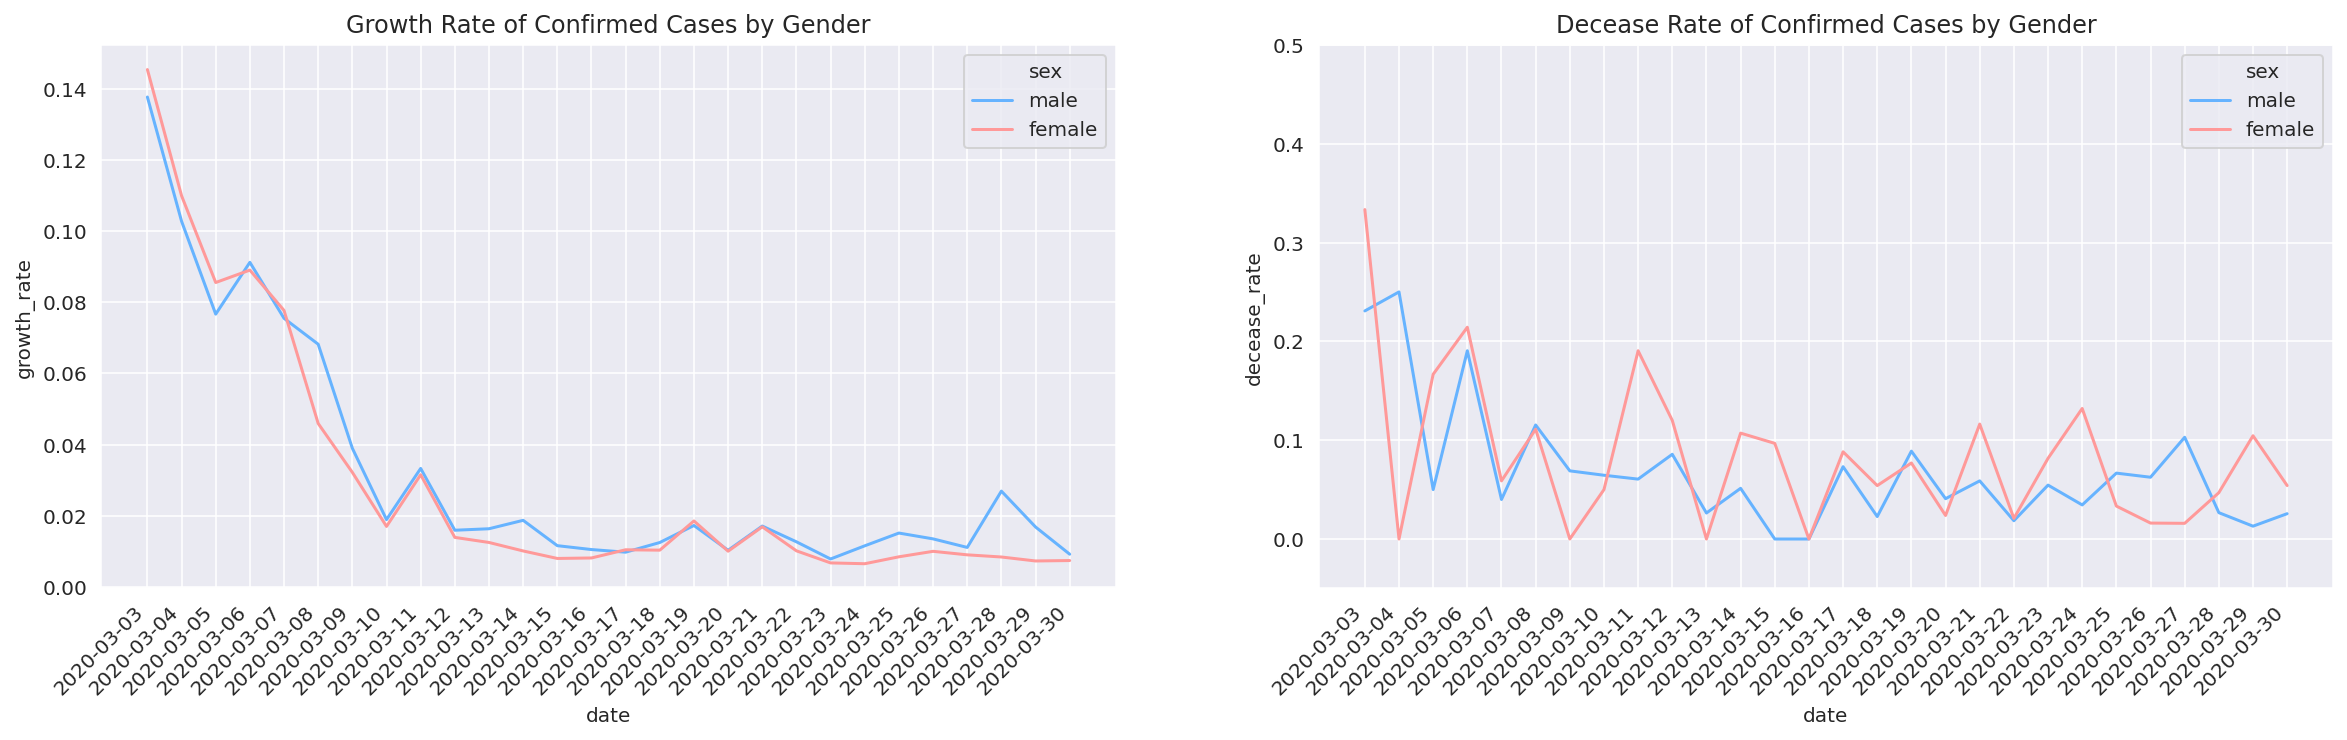

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Growth rate of confirmed cases (Index - male: even, female: odd)
ax1.title.set_text('Growth Rate of Confirmed Cases by Gender')
gender['growth_rate'] = gender.groupby('sex')[['confirmed']].pct_change()
sns.lineplot(data=gender, x='date', y='growth_rate', hue='sex', ax=ax1)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Decease rate of confirmed cases
ax2.title.set_text('Decease Rate of Confirmed Cases by Gender')
# Limiting y axis range to reduce fluctuations in graph
ax2.set(ylim=(-0.05, 0.5))
gender['decease_rate'] = gender.groupby('sex')[['deceased']].pct_change()
sns.lineplot(data=gender, x='date', y='decease_rate', hue='sex', ax=ax2)
plt.xticks(rotation=45, ha='right')

plt.show()

### **Analysis & Conclusion**

1. More females are infected than males.
2. The growth rate of confirmed cases is similar regardless of genders.
3. Both genders show a similar trend of decease rate.

Gender **isn't** a significant factor that influences the infection rate. (No correlation)

The reason why more females were infected than men might be due to geological reasons or different lifestyles.

## **By Age**

### **Assumption**

Age group 10s and 20s will be most infected as they are more active and study in a crowded place such as academy or school.<br>As people age, they will be more susceptible of getting infected as their immune system weakens.

### **Visualization**

In [7]:
# Importing data: Age
age = pd.read_csv(os.path.join(DIR_PATH, 'TimeAge.csv'))
print('Unique items: {0}'.format(len(age['age'].unique())))
age.head(9)

Unique items: 9


,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1
5,2020-03-02,0,50s,834,5
6,2020-03-02,0,60s,530,6
7,2020-03-02,0,70s,192,6
8,2020-03-02,0,80s,81,3


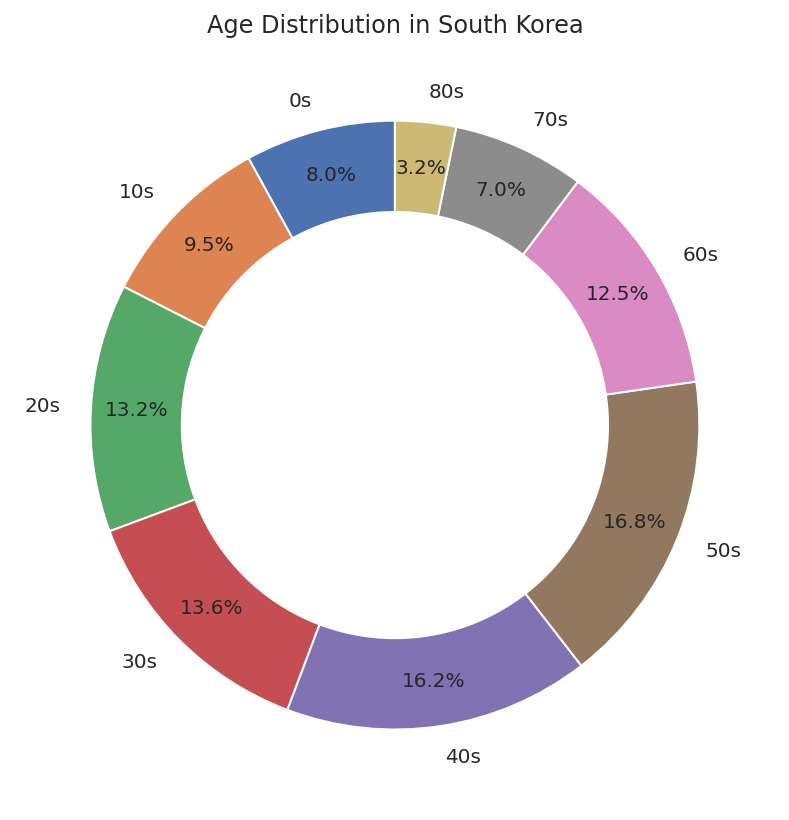

In [8]:
sns.set_palette('deep')
pop_dist_age = pop_dist.iloc[0, 2:11].str.replace(',', '')

# Population distribution by age
plt.figure(figsize=(7, 7))
plt.title('Age Distribution in South Korea')
plt.pie(pop_dist_age, labels=pop_dist_age.index, 
        autopct='%.1f%%', startangle=90, pctdistance=0.85)
plt.gcf().gca().add_artist(plt.Circle((0, 0), 0.7, fc='white'))
plt.show()

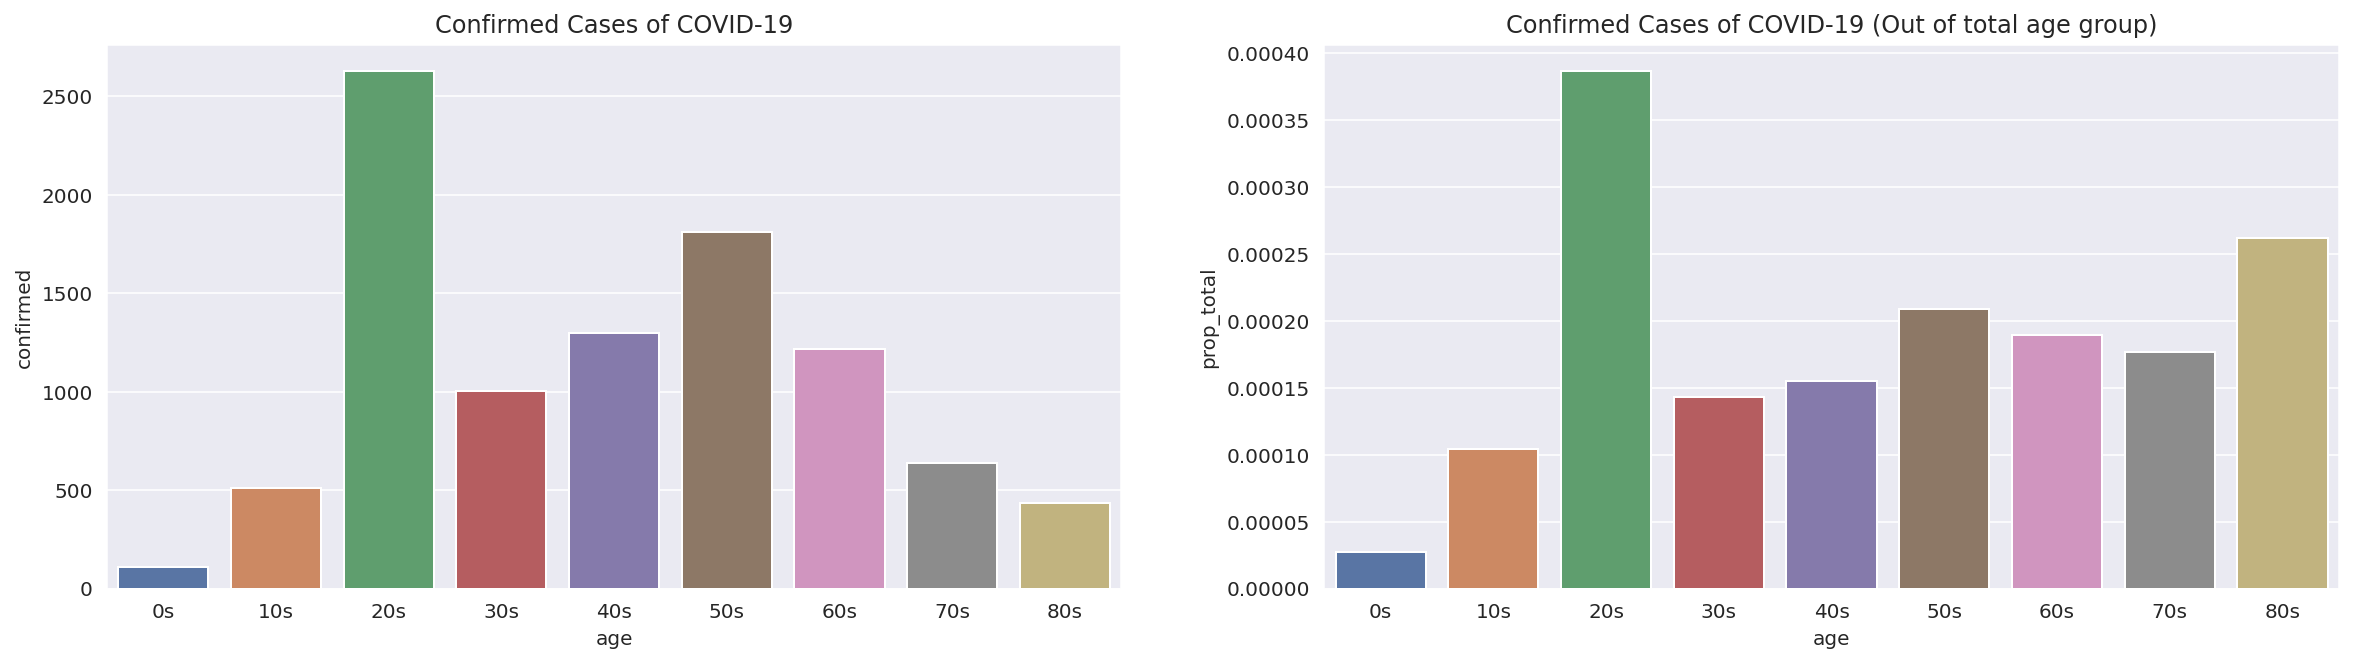

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Confirmed cases by age
ax1.title.set_text('Confirmed Cases of COVID-19')
sns.barplot(data=age[-9:], x='age', y='confirmed', ax=ax1)

# Create new column of total people in that age group
pop_dist_age = pop_dist.iloc[0, 2:11].str.replace(',', '')
age['age_total'] = np.tile(pop_dist_age, len(age) // len(pop_dist_age) + 1)[:len(age)]

# Create proportion column
age['prop_total'] = age['confirmed'] / age['age_total'].astype(float)

# Proportion of confirmed cases by age to total people in age group
ax2.title.set_text('Confirmed Cases of COVID-19 (Out of total age group)')
sns.barplot(data=age[-9:], x='age', y='prop_total', ax=ax2)

plt.show()

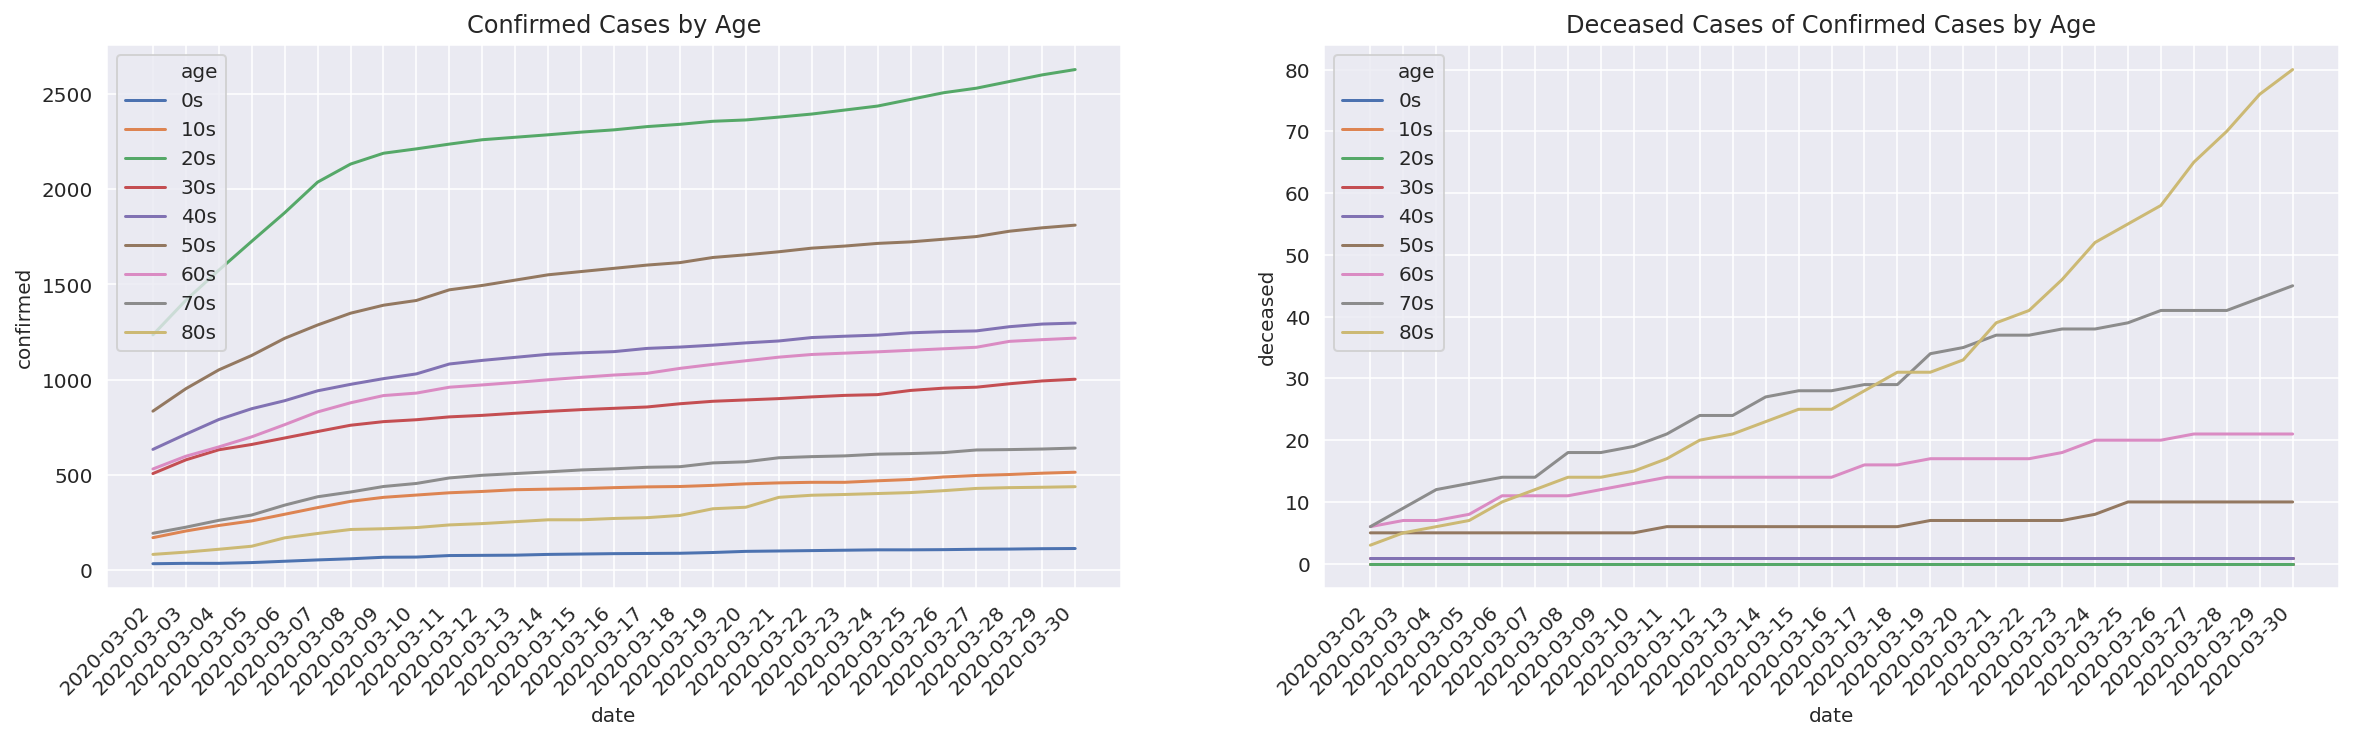

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Confirmed cases by age
ax1.title.set_text('Confirmed Cases by Age')
sns.lineplot(data=age, x='date', y='confirmed', hue='age', ax=ax1)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Deceased cases by age
ax2.title.set_text('Deceased Cases of Confirmed Cases by Age')
sns.lineplot(data=age, x='date', y='deceased', hue='age', ax=ax2)
plt.xticks(rotation=45, ha='right')

plt.show()

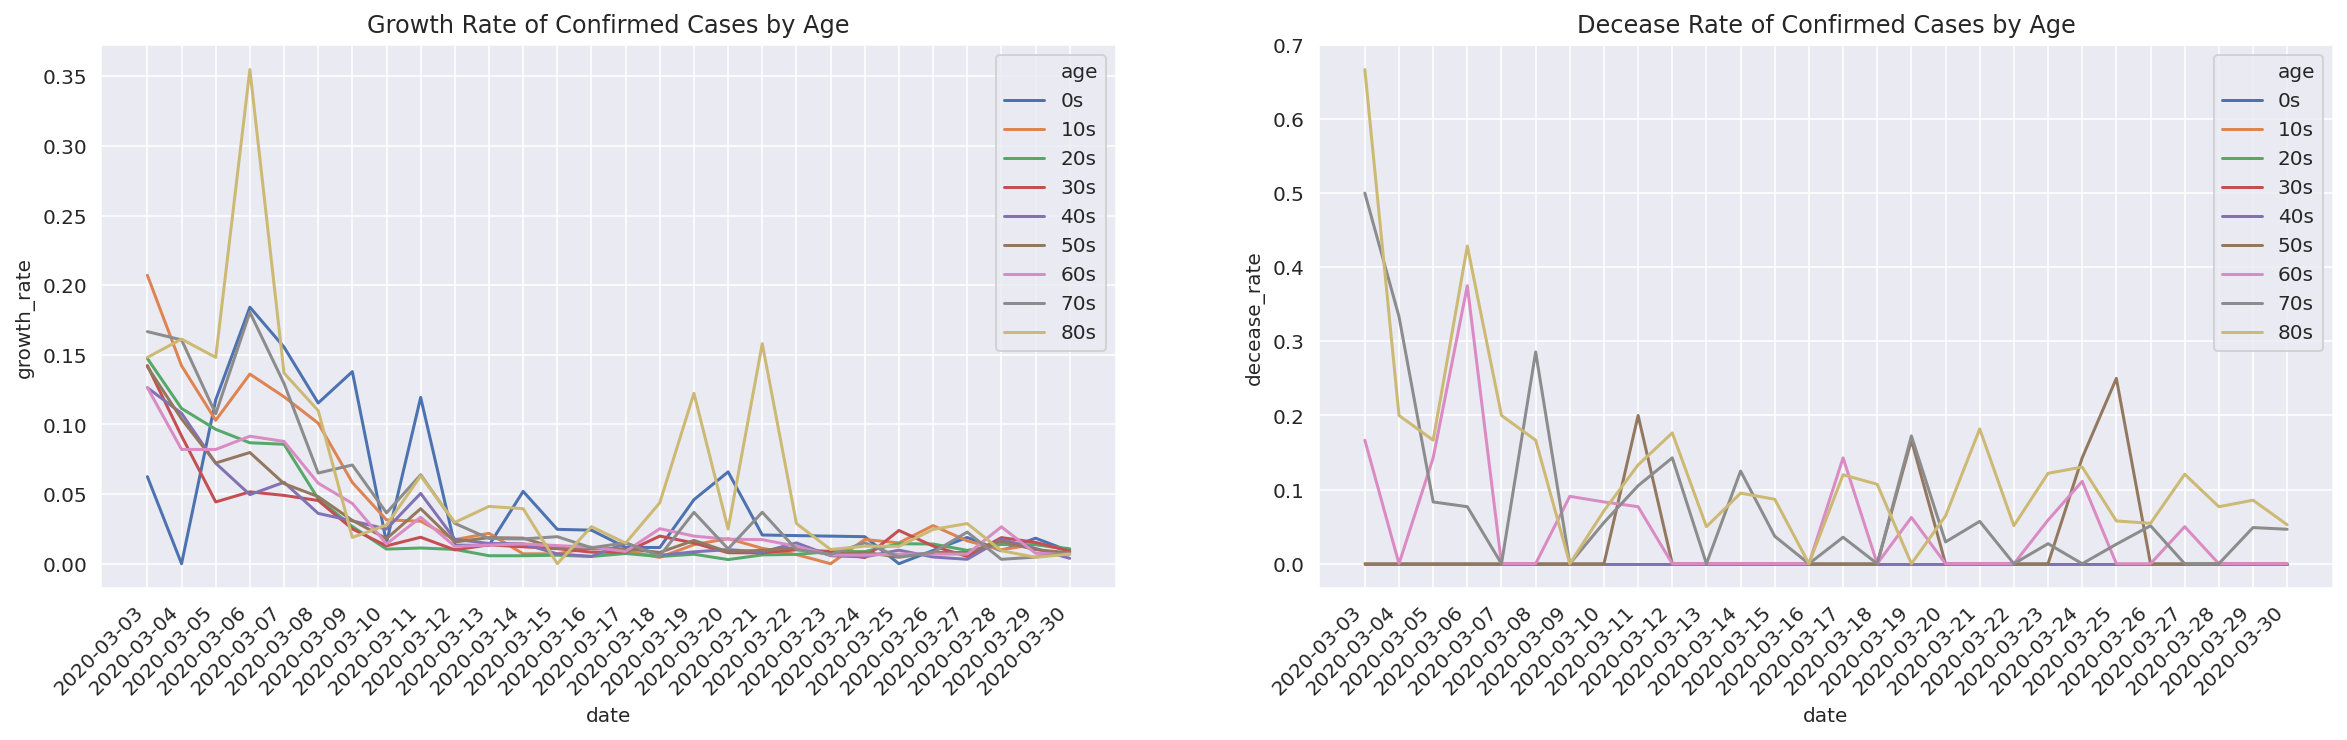

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Growth rate of confirmed cases
ax1.title.set_text('Growth Rate of Confirmed Cases by Age')
age['growth_rate'] = age.groupby('age')[['confirmed']].pct_change()
sns.lineplot(data=age, x='date', y='growth_rate', hue='age', ax=ax1)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Decease rate of confirmed cases
ax2.title.set_text('Decease Rate of Confirmed Cases by Age')
age['decease_rate'] = age.groupby('age')[['deceased']].pct_change()
sns.lineplot(data=age, x='date', y='decease_rate', hue='age', ax=ax2)
plt.xticks(rotation=45, ha='right')

plt.show()

### **Analysis & Conclusion**

1. Although 20s only take up 13.2% of all populations in South Korea, they are the most infected and has the highest infection rate among all other age groups.
2. Older people are more prone to get COVID-19 and are more likely to get deceased.
3. Trend of growth and decease rate seems similar.

Age seems to be a significant feature that influences infection rate.

High infection rate of age group 20s can might be explained by their social activeness as young people tend to move around places more than older people. As people get older, their immunity tends to drop, which might be the reason why there are more cases of infections as people age.

## **By Location**

### **Assumption**

Seoul and metropolitan cities would have relatively high infection cases due to their floating population and high population density.

### **Visualization**

#### **TimeProvince.csv**

In [12]:
# Importing data: Location
location = pd.read_csv(os.path.join(DIR_PATH, 'TimeProvince.csv'))
prov_num = len(location['province'].unique())
print(f'There are {prov_num} provinces in this dataset')

# Latest data of confirmed cases by province
loc_latest = location.iloc[-prov_num:]
loc_latest = loc_latest.sort_values('confirmed', ascending=False).reset_index(
                        drop=True).drop('time', axis=1)
loc_latest

There are 17 provinces in this dataset


,date,province,confirmed,released,deceased
0,2020-03-30,Daegu,6624,3837,111
1,2020-03-30,Gyeongsangbuk-do,1298,772,38
2,2020-03-30,Gyeonggi-do,463,160,5
3,2020-03-30,Seoul,426,92,0
4,2020-03-30,Chungcheongnam-do,127,83,0
5,2020-03-30,Busan,118,87,3
6,2020-03-30,Gyeongsangnam-do,95,65,0
7,2020-03-30,Incheon,58,15,0
8,2020-03-30,Sejong,46,12,0
9,2020-03-30,Chungcheongbuk-do,44,21,0


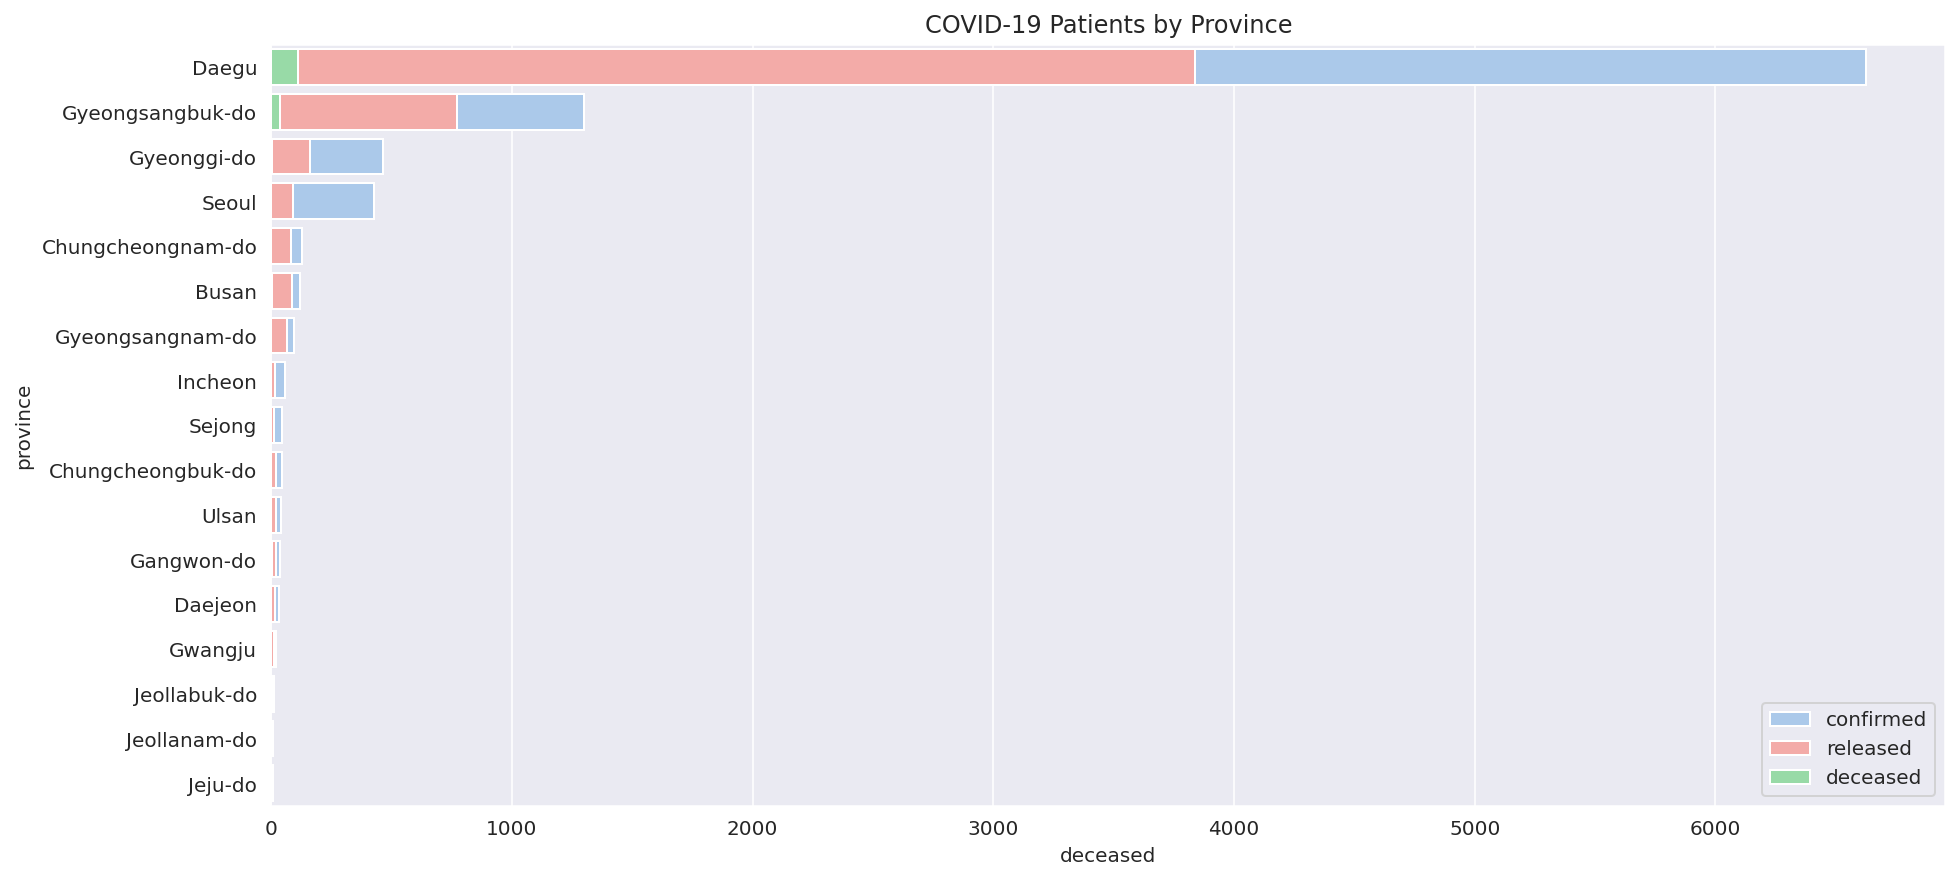

In [13]:
# Latest number of confirmed & released & deceased people
fig, ax1 = plt.subplots(figsize=(15, 7))
ax1.title.set_text('COVID-19 Patients by Province')
sns.set_color_codes("pastel")
sns.barplot(data=loc_latest, x='confirmed', y='province',  label='confirmed',
            color='b', ci=None, estimator=sum)
sns.barplot(data=loc_latest, x='released', y='province', label='released',
            color='r', ci=None, estimator=sum)
sns.barplot(data=loc_latest, x='deceased', y='province', label='deceased',
            color='g', ci=None, estimator=sum)
ax1.legend(loc='lower right', frameon=True)
fig.show()

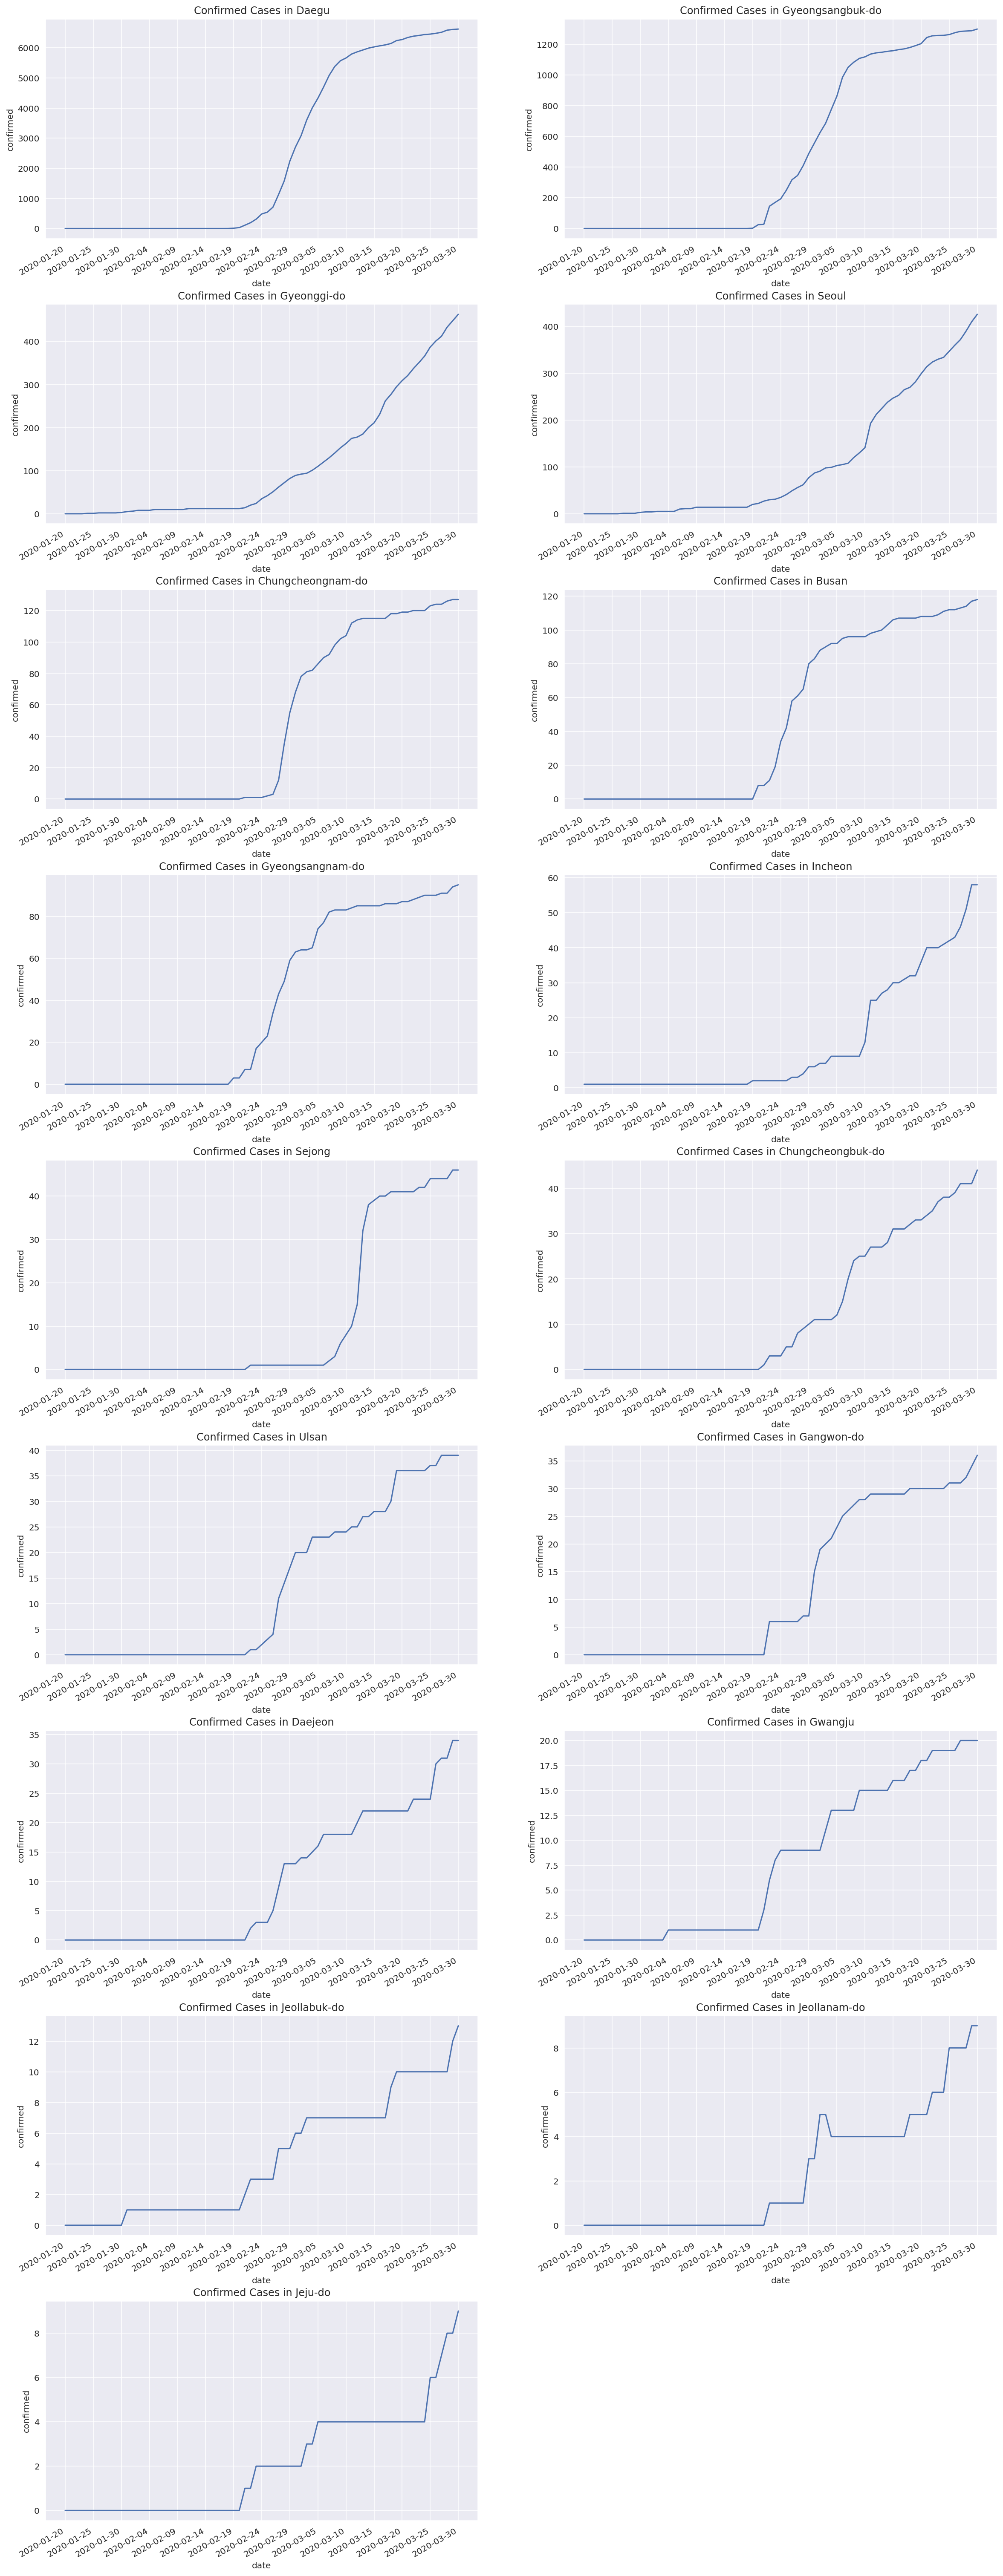

In [14]:
# Confirmed cases in each province (accumulated)
rows = int(prov_num / 2 + 1)
fig, ax = plt.subplots(rows, 2, figsize=(20, 6 * rows))
fig.subplots_adjust(hspace=.3)

for i, province in enumerate(loc_latest['province']):
    r, c = int(i / 2), i % 2
    sns.lineplot(data=location[location['province'] == province],
                 x='date', y='confirmed', ax=ax[r, c])
    ax[r, c].set_title(f'Confirmed Cases in {province}')
    ax[r, c].xaxis.set_major_locator(ticker.MultipleLocator(base=5))
    plt.setp(ax[r, c].xaxis.get_majorticklabels(), rotation=30, ha='right')

fig.delaxes(ax[rows - 1][rows * 2 - prov_num])
fig.show()

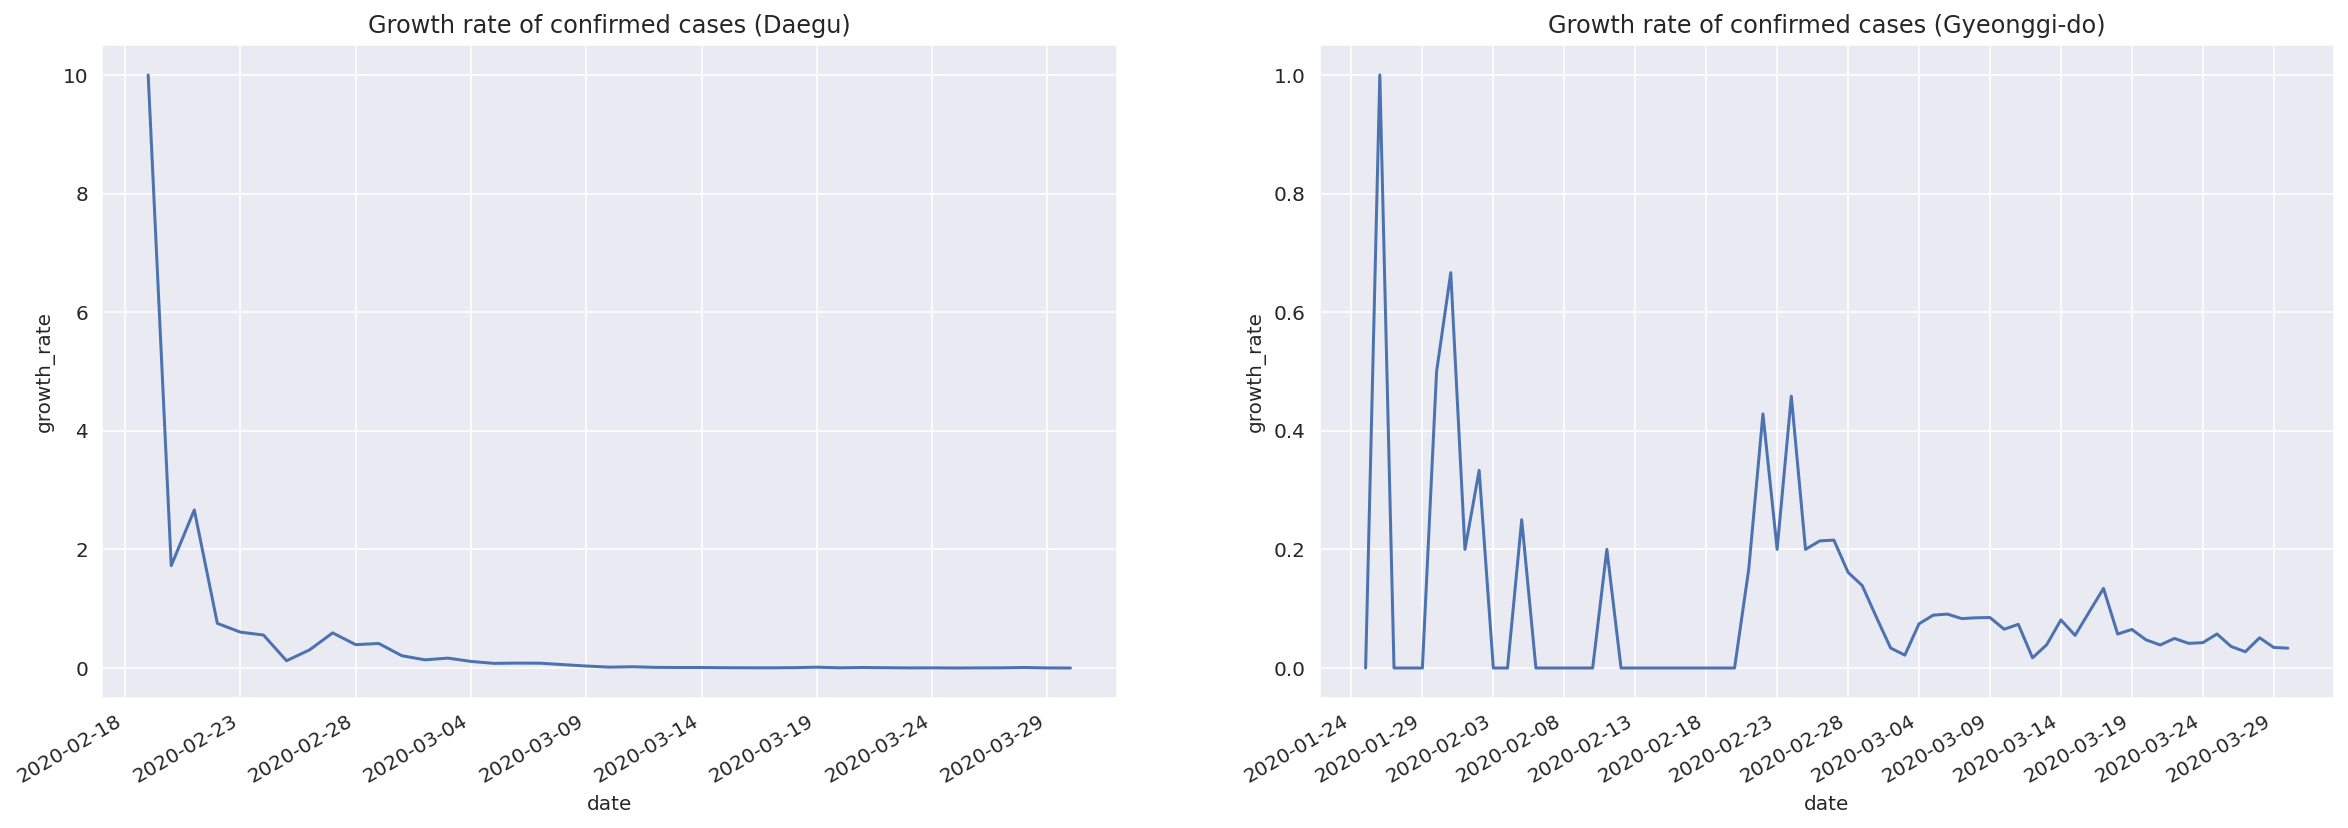

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))
location['growth_rate'] = location.groupby('province')[['confirmed']].pct_change()

# Growth rate of confirmed cases in Daegu
ax1.set_title('Growth rate of confirmed cases (Daegu)')
sns.lineplot(data=location[location['province'] == 'Daegu'], x='date', y='growth_rate', ax=ax1)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=30, ha='right')

# Growth Rate of confirmed cases in Gyeonggi-do
ax2.set_title('Growth rate of confirmed cases (Gyeonggi-do)')
sns.lineplot(data=location[location['province'] == 'Gyeonggi-do'], x='date', y='growth_rate', ax=ax2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=30, ha='right')

fig.show()

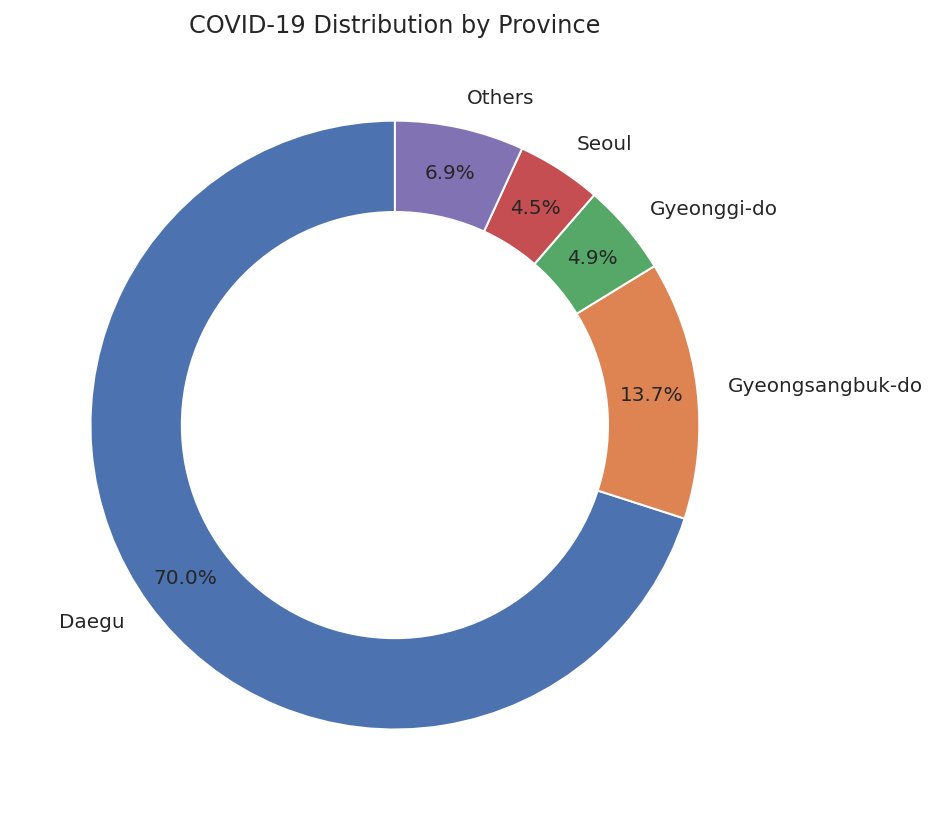

In [16]:
# Proportion out of total confirmed cases by province
loc_latest['proportion'] = round(loc_latest['confirmed'] / sum(loc_latest['confirmed']) * 100, 2)

# Combine provinces that consists less than 2% of total cases
loc_latest.loc['17',:] = loc_latest.iloc[4:, :].sum()
loc_latest.loc['17',['date', 'province']] = ['2020-03-30', 'Others']

sns.set_palette('deep')
loc_latest_w_etc = loc_latest.iloc[[0, 1, 2, 3, 17], [1, 5]]

# COVID-19 distribution by province
plt.figure(figsize=(7, 7))
plt.title('COVID-19 Distribution by Province')
plt.pie(loc_latest_w_etc['proportion'], labels=loc_latest_w_etc['province'], 
        autopct='%.1f%%', startangle=90, pctdistance=0.85)
plt.gcf().gca().add_artist(plt.Circle((0, 0), 0.7, fc='white'))
plt.show()

#### **Region.csv**

In [17]:
# Importing data: Region
region = pd.read_csv(os.path.join(DIR_PATH, 'Region.csv'))
region = region.drop('nursing_home_count', axis=1)
# region = region.drop(['latitude', 'longitude', 'nursing_home_count'], axis=1)
# Drop column with same value and sort by academy_ratio
region_overview = region[region['province'] == region['city']].drop('city',
                  axis=1).drop(243).sort_values('academy_ratio', 
                  ascending=False).reset_index(drop=True)
region_overview.head()

,code,province,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio
0,13000,Gwangju,35.160467,126.851392,155,312,17,2.38,13.57,6.4
1,16000,Ulsan,35.539797,129.311538,119,200,4,2.21,11.76,5.2
2,50000,Jeollabuk-do,35.820308,127.108791,419,519,19,2.12,20.60,10.9
3,17000,Sejong,36.480132,127.289021,48,60,3,1.78,9.48,3.8
4,61000,Gyeongsangnam-do,35.238294,128.692397,501,686,21,1.78,16.51,9.1


In [18]:
# Add latitude and longtitude
loc_latest = loc_latest.merge(
    region_overview[['province', 'latitude','longitude']],
    on = 'province')
loc_latest['latitude'] = loc_latest['latitude'].astype(float)
loc_latest['longitude'] = loc_latest['longitude'].astype(float)
loc_latest.head()

,date,province,confirmed,released,deceased,proportion,latitude,longitude
0,2020-03-30,Daegu,6624.0,3837.0,111.0,70.03,35.872150,128.601783
1,2020-03-30,Gyeongsangbuk-do,1298.0,772.0,38.0,13.72,36.576032,128.505599
2,2020-03-30,Gyeonggi-do,463.0,160.0,5.0,4.89,37.275119,127.009466
3,2020-03-30,Seoul,426.0,92.0,0.0,4.50,37.566953,126.977977
4,2020-03-30,Chungcheongnam-do,127.0,83.0,0.0,1.34,36.658976,126.673318


In [28]:
# COVID-19 infection distribution
map_southKR = folium.Map(location=[35.9, 128], tiles="cartodbpositron",
                         zoom_start=7, max_zoom=9, min_zoom=5)
folium.Choropleth(geo_data=os.path.join(DIR_PATH, 'province_geo.json'),
                  fill_color='#ffff66',).add_to(map_southKR)

for i in range(0, len(loc_latest)):
    folium.Circle(
        location=[loc_latest.iloc[i]['latitude'], loc_latest.iloc[i]['longitude']],
        tooltip="<h5 style='text-align:center;font-weight: bold'>" + 
                loc_latest.iloc[i]['province'] + "</h5><hr style='margin:10px;'>" +
                "<ul style='align-item:left;padding-left:20px;padding-right:20px'>" +
                "<li>Confirmed: " + str(loc_latest.iloc[i]['confirmed']) + "</li>" +
                "<li>Deaths: " + str(loc_latest.iloc[i]['deceased']) + "</li>" +
                "<li>Mortality Rate: " + str(round(loc_latest.iloc[i]['deceased'] /
                                                   (loc_latest.iloc[i]['confirmed'] + .000001) * 100, 2)) + 
                "%</li></ul>",
        radius=int((np.log(loc_latest.iloc[i]['confirmed'])))*5000,
        color='#ff3333',
        fill_color='#ff0000',
        fill=True).add_to(map_southKR)

map_southKR

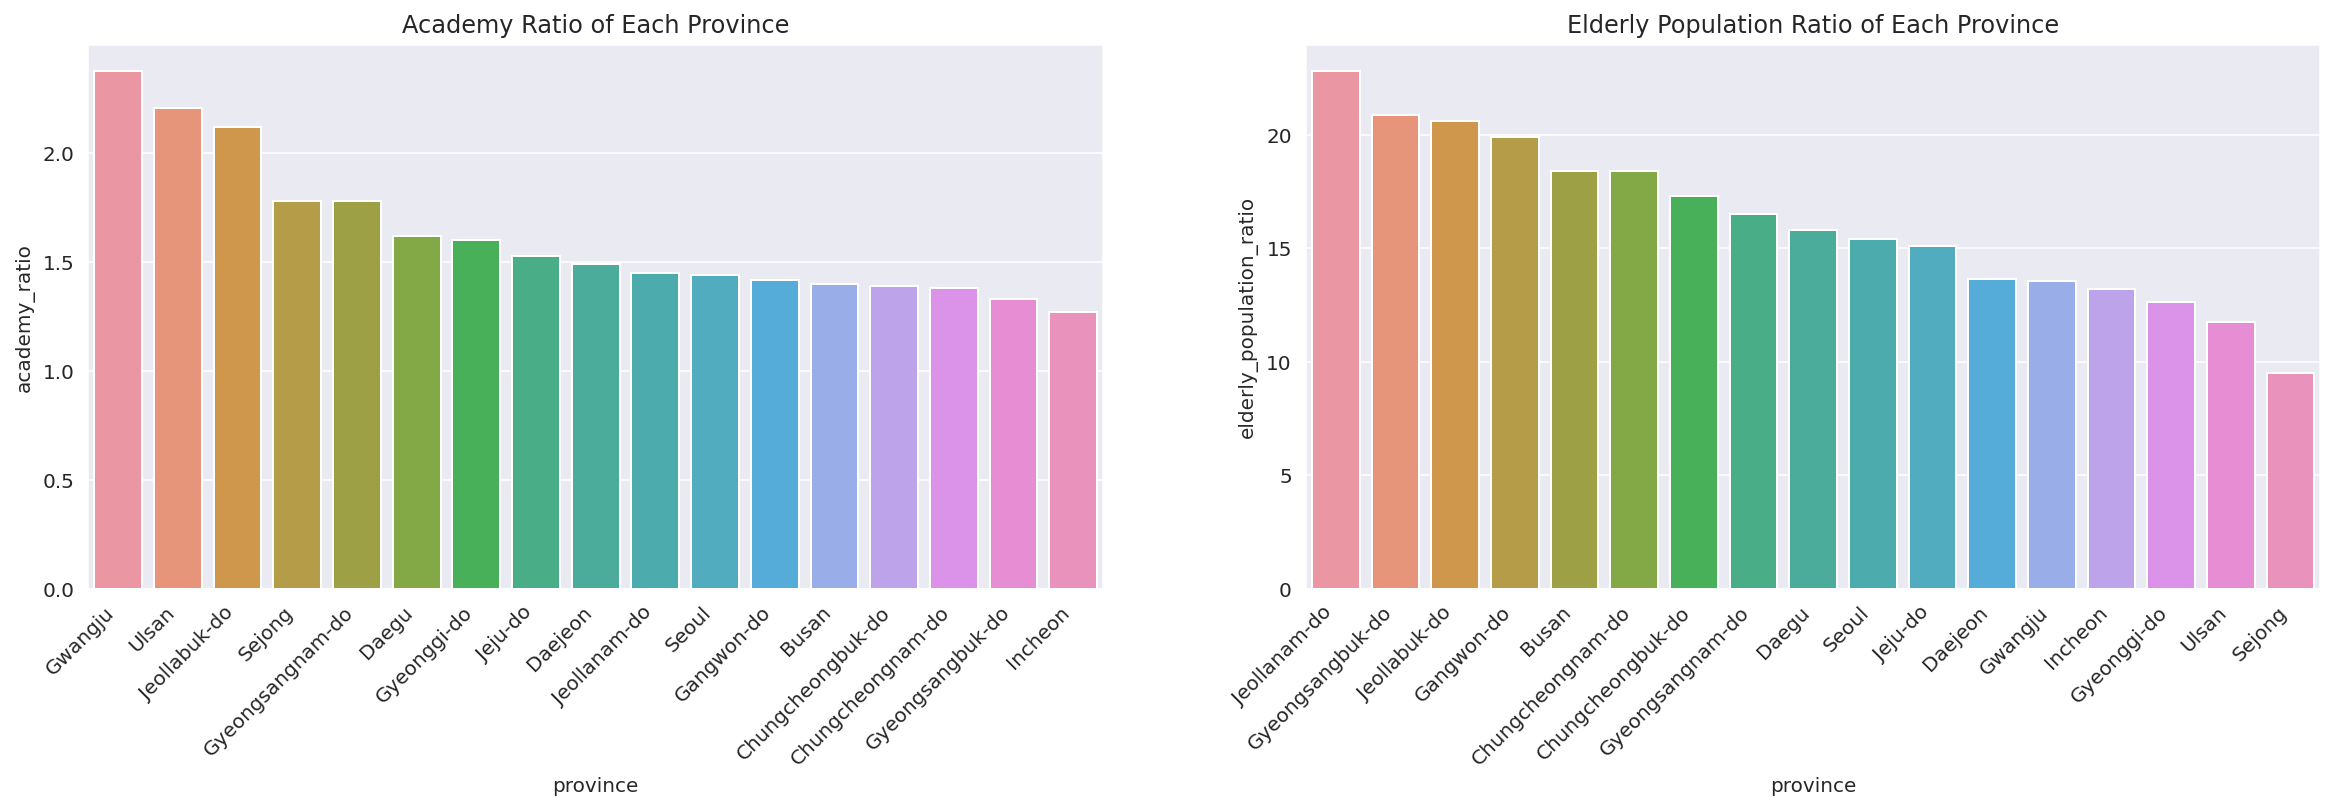

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Academy ratio of each province
ax1.title.set_text('Academy Ratio of Each Province')
sns.barplot(data=region_overview, x='province', y='academy_ratio', ax=ax1)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

region_overview = region_overview.sort_values('elderly_population_ratio', 
                                              ascending=False).reset_index(drop=True)

# Elderly population ratio of each province
ax2.title.set_text('Elderly Population Ratio of Each Province')
sns.barplot(data=region_overview, x='province', y='elderly_population_ratio', ax=ax2)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.show()

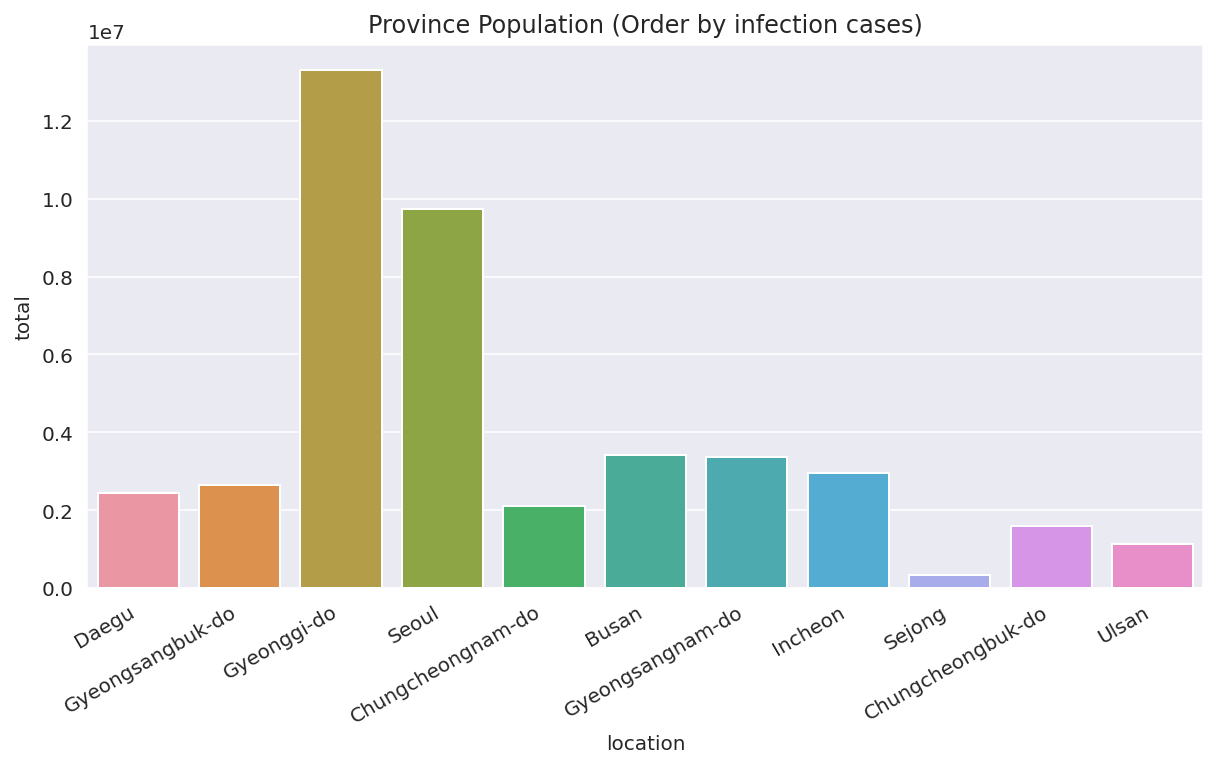

In [21]:
# DataFrame only with province and population value
pop_dist_prov = pop_dist.copy(deep=True)
pop_dist_prov['total'] = pop_dist_prov['total'].str.replace(',', '').astype(int)
pop_dist_prov = pop_dist_prov.sort_values('total', ascending=False).reset_index(
    drop=True).drop(pop_dist_prov.columns[2:13], axis=1)
by_i_case = pop_dist_prov.loc[[7, 6, 1, 2, 8, 3, 4, 5, 17, 11, 15], :]
by_i_case['location'] = ['Daegu','Gyeongsangbuk-do','Gyeonggi-do','Seoul',
                 'Chungcheongnam-do','Busan','Gyeongsangnam-do','Incheon',
                 'Sejong','Chungcheongbuk-do','Ulsan']

# Province population ordered by infection cases
plt.figure(figsize=(10, 5))
plt.title('Province Population (Order by infection cases)')
sns.barplot(data=by_i_case, x='location', y='total')
plt.xticks(rotation=30, ha='right')
plt.show()

### **Analysis & Conclusion**

1. Less than 100 people were infected for the first month but infection case has grown exponentially for the following months.
2. Top 3 provinces with high COVID-19 infection take up 90% of total cases.
3. It seems COVID-19 has gone to a lull (Slope is decreasing) in provinces except Gyeonggi-do, Seoul, and Incheon.
4. The infection growth rate in Gyeonggi-do shows several spikes, which means there were a sudden increase in infection cases that might have been caused by collective infection due to an event or work.
5. Academy ratio and elderly population ratio of a province seem to have no correlation with infection cases in particular province.
6. There tends to be more confirmed cases of COVID-19 in provinces with high popultaion except Daegu and Gyeongsangbuk-do.

Location seems to be a significant feature that influences infection rate.

However, it seems location is not the major factor that determines the infection rate.
<br>The reason why Daegu and Gyeongsangbuk-do have a high number of patients relative to their population are because infected **Sincheonji believers** had a huge prayer meeting, causing of exponential growth, and many of them traveled from Daegu to Gyeongsangbuk-do.

## **By Time**

### **Assumption**

Graph of COVID-19 confirmed cases will follow SIR epidemic model.

![SIR Model](https://drive.google.com/uc?id=1rjMH9cdoP_V9Kt2OGCfQHP5NJoBxSPA9)

where

> **S(t)** are those susceptible but not yet infected with the disease<br>
> **I(t)** is the number of infectious individuals<br>
> **R(t)** are those individuals who have recovered from the disease and now have immunity to it.

### **Visualization**

In [22]:
# Importing data: Time
time = pd.read_csv(os.path.join(DIR_PATH, 'Time.csv'))
time.head()

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0


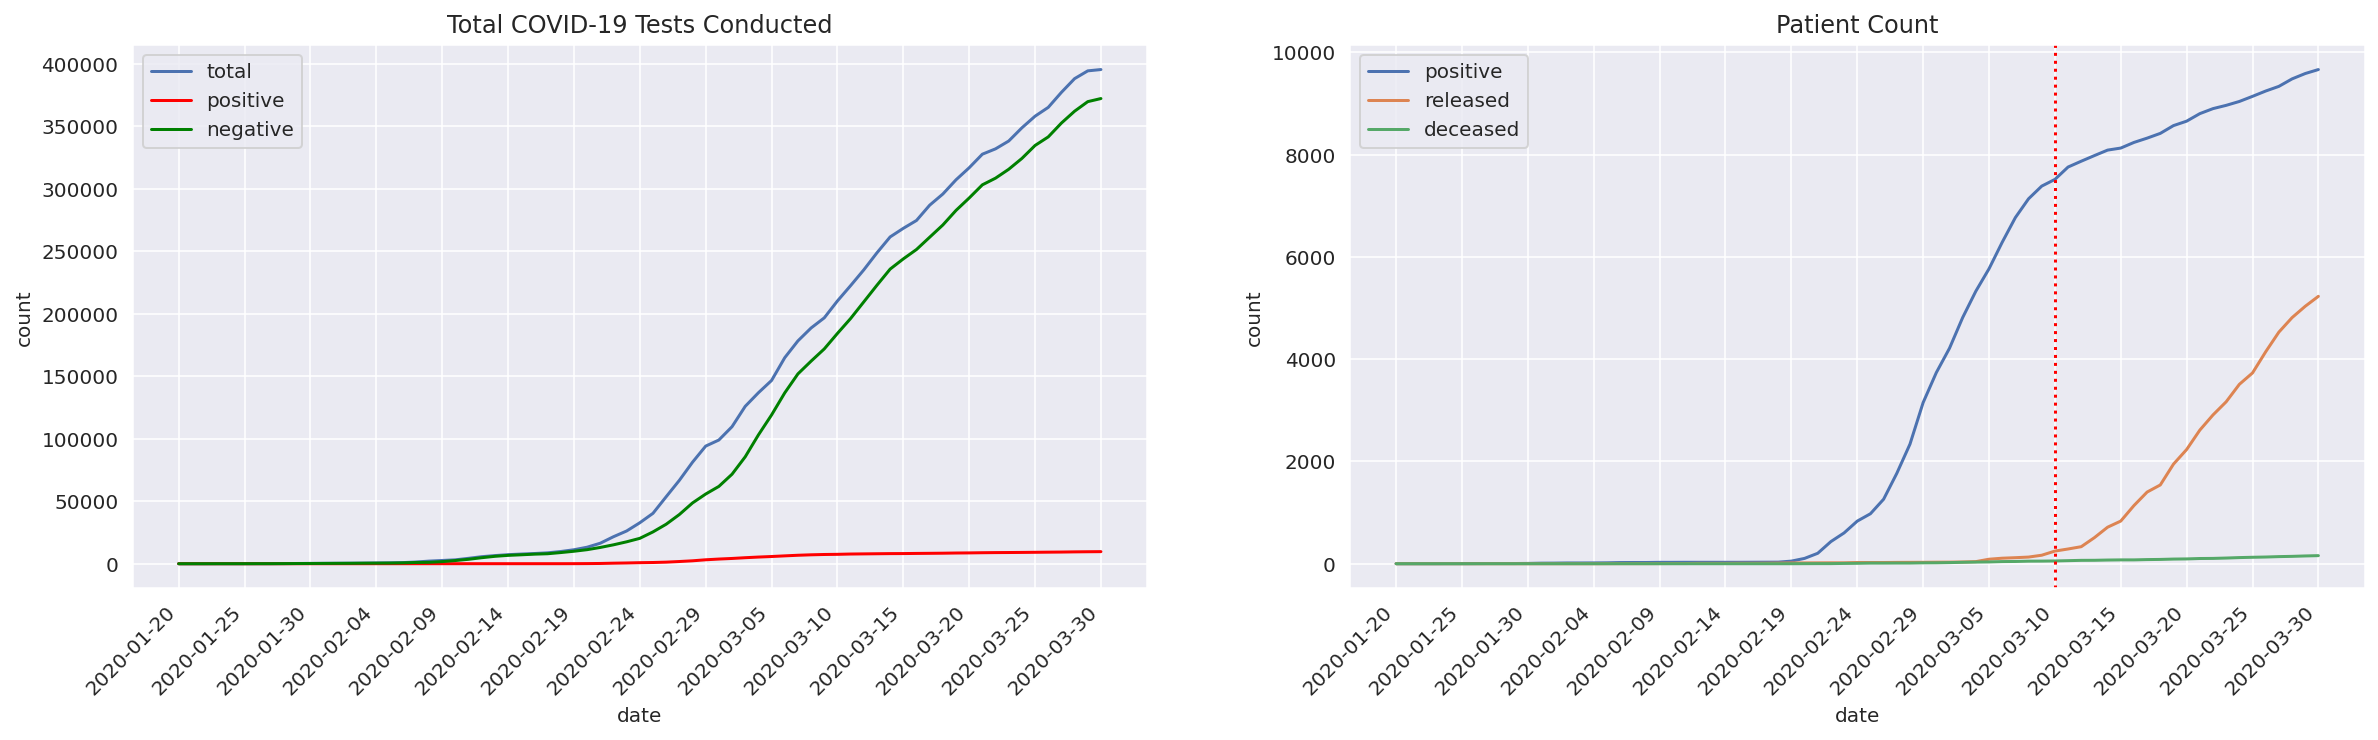

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Number of tests conducted
ax1.title.set_text('Total COVID-19 Tests Conducted')
sns.lineplot(data=time, x='date', y='test', label='total', ax=ax1)
sns.lineplot(data=time, x='date', y='confirmed', color='red', label='positive', ax=ax1)
sns.lineplot(data=time, x='date', y='negative', color='green', label='negative', ax=ax1)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
ax1.set(ylabel='count')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Positive & Released & Deceased cases
ax2.title.set_text('Patient Count')
sns.lineplot(data=time, x='date', y='confirmed', label='positive', ax=ax2)
sns.lineplot(data=time, x='date', y='released', label='released', ax=ax2)
sns.lineplot(data=time, x='date', y='deceased', label='deceased', ax=ax2)

ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
ax2.set(ylabel='count')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Draw vertical line in patient count graph
ax2.axvline('2020-03-10', 0, 10000, color='red', linestyle='dotted')

plt.show()

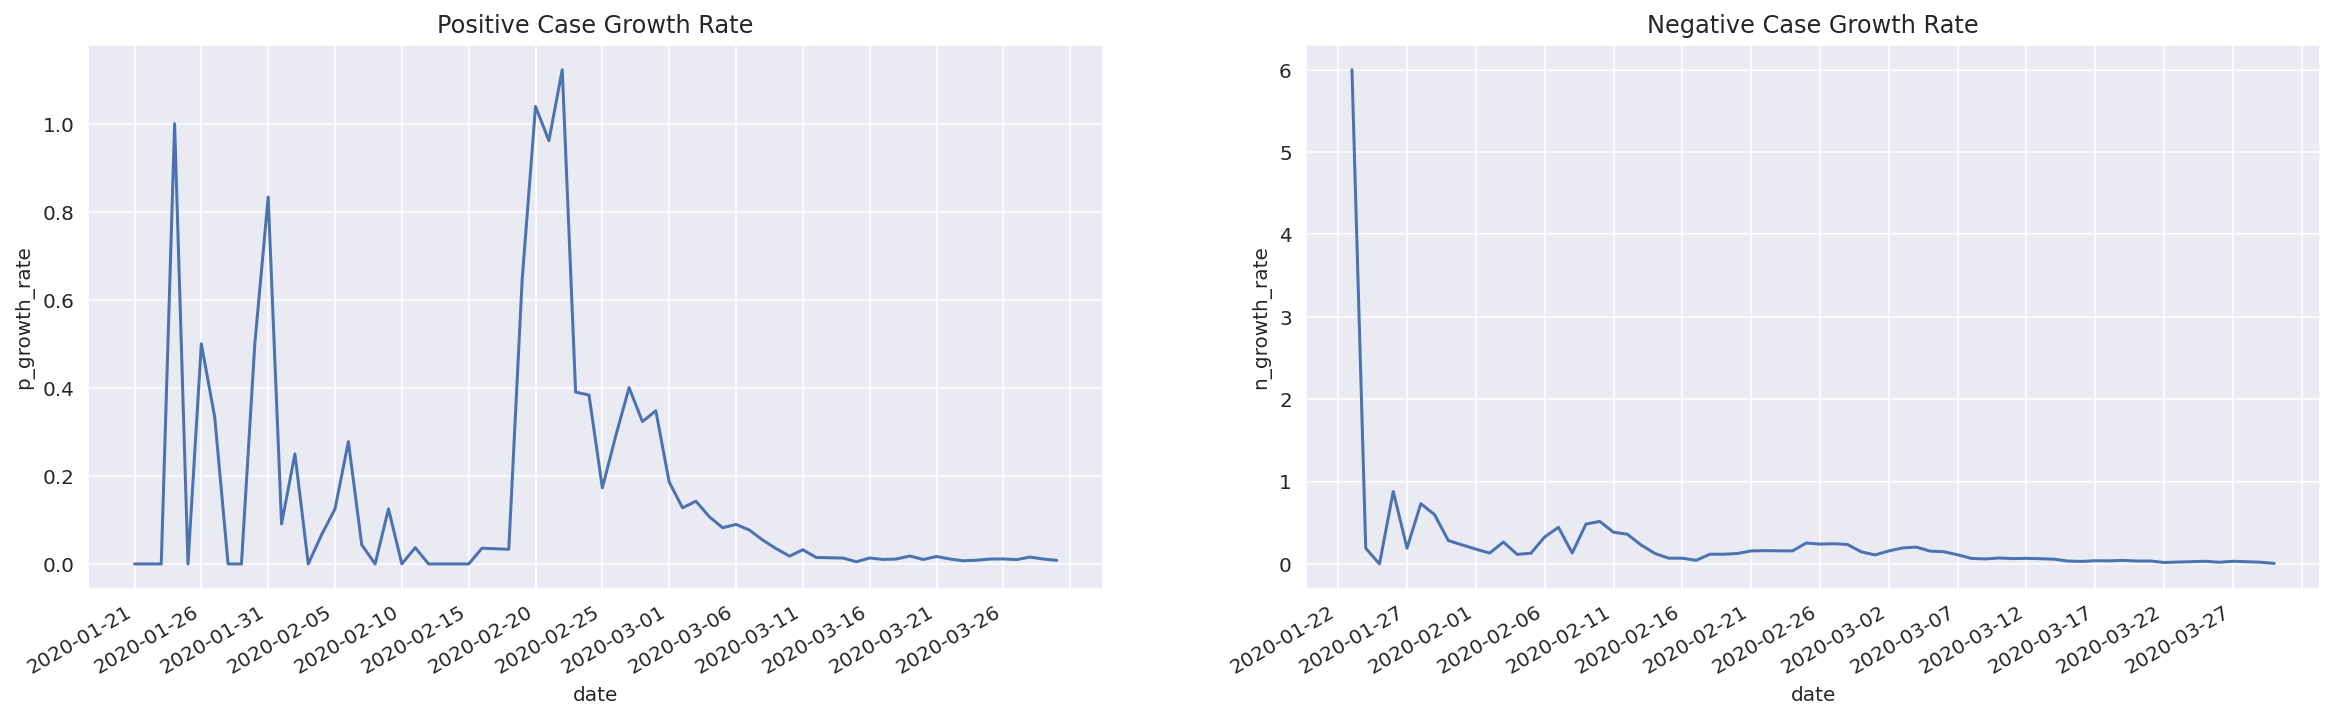

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
time['p_growth_rate'] = time['confirmed'].pct_change()
time['n_growth_rate'] = time['negative'].pct_change()

# Growth rate of positive cases
ax1.set_title('Positive Case Growth Rate')
sns.lineplot(data=time, x='date', y='p_growth_rate', ax=ax1)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=30, ha='right')

# Growth rate of negative cases
ax2.set_title('Negative Case Growth Rate')
sns.lineplot(data=time, x='date', y='n_growth_rate', ax=ax2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=30, ha='right')

fig.show()

In [25]:
# Proportion by total population
time_f = time.tail(1)
time_latestT = time_f.test.values[0]
time_latestP = time_f.confirmed.values[0]
time_latestN = time_f.negative.values[0]
pop_total = int(pop_dist.iat[0, 1].replace(',', ''))

print('Percentage of people tested out of total population: {0}%\n'.format(round(time_latestT / pop_total * 100, 2)) + 
      'Percentage of positive cases out of people tested: {0}%\n'.format(round(time_latestP / time_latestT * 100, 2)) + 
      'Percentage of negative cases out of people tested: {0}%'.format(round(time_latestN / time_latestT * 100, 2)))

Percentage of people tested out of total population: 0.76%
Percentage of positive cases out of people tested: 2.44%
Percentage of negative cases out of people tested: 94.13%


### **Analysis & Conclusion**

1. Total number of conducted tests and negative results are increasing linearly while the rate of positive results is slowly decreasing unlike its exponential growth in the first.
2. Since 2020-03-10, rate of positive results is decreasing and rate of released patients is increasing rapidly.
3. From spikes in the positive case growth rate, we can infer some event has happened just before, causing collective infection.

A Graph of time vs infection cases follows the SIR epidemic model.

## **By Search Trend**

### **Assumption**

The search keywords related to COVID-19 would have been searched the most when the growth rate of positive cases is at its maximum.

### **Visualization**

In [60]:
# Importing data: Search Trend
searchtrend = pd.read_csv(os.path.join(DIR_PATH, 'SearchTrend.csv'))
searchtrend.head(1485)

,date,cold,flu,pneumonia,coronavirus
0,2016-01-01,0.11663,0.05590,0.15726,0.00736
1,2016-01-02,0.13372,0.17135,0.20826,0.00890
2,2016-01-03,0.14917,0.22317,0.19326,0.00845
3,2016-01-04,0.17463,0.18626,0.29008,0.01145
4,2016-01-05,0.17226,0.15072,0.24562,0.01381
...,...,...,...,...,...
1480,2020-01-20,0.19217,0.70343,3.63716,20.69610
1481,2020-01-21,0.22462,0.59789,4.31987,35.33284
1482,2020-01-22,0.23808,0.56661,3.66416,29.74474
1483,2020-01-23,0.30308,0.55625,3.18035,100.00000


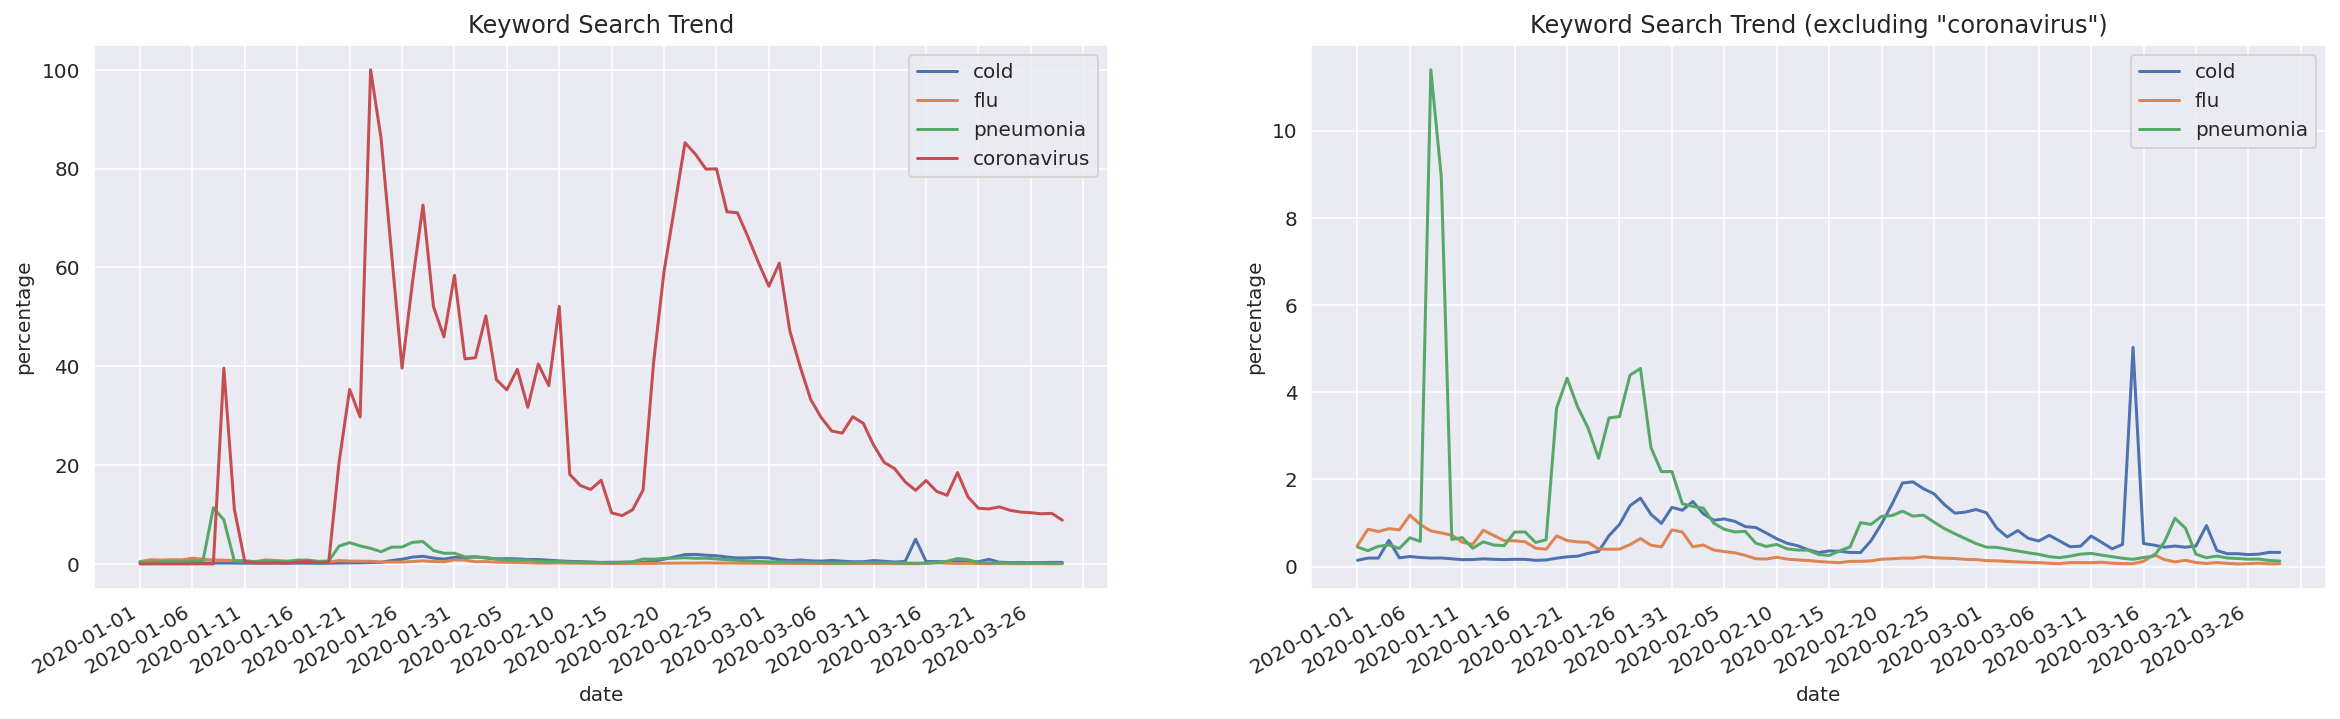

In [61]:
searchTrend_2020 = searchtrend.iloc[1461:, :]
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Search proportion of keywords related to COVID-19
ax1.title.set_text('Keyword Search Trend')
sns.lineplot(data=searchTrend_2020, x='date', y='cold', label='cold', ax=ax1)
sns.lineplot(data=searchTrend_2020, x='date', y='flu', label='flu', ax=ax1)
sns.lineplot(data=searchTrend_2020, x='date', y='pneumonia', label='pneumonia', ax=ax1)
sns.lineplot(data=searchTrend_2020, x='date', y='coronavirus', label='coronavirus', ax=ax1)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
ax1.set(ylabel='percentage')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=30, ha='right')

# Search proportion of keywords related to COVID-19 except coronavirus
ax2.title.set_text('Keyword Search Trend (excluding "coronavirus")')
sns.lineplot(data=searchTrend_2020, x='date', y='cold', label='cold', ax=ax2)
sns.lineplot(data=searchTrend_2020, x='date', y='flu', label='flu', ax=ax2)
sns.lineplot(data=searchTrend_2020, x='date', y='pneumonia', label='pneumonia', ax=ax2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
ax2.set(ylabel='percentage')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=30, ha='right')

fig.show()